# RecSys Netflix dataset

Building a RecSys for the Netflix dataset

This dataset contains movie ratings from Netflix users. The goal is to build a RecSys that provides personalized movie recommendations to users based on their preferences.

Researcher<br>
David Kakanis - 500783676<br>


## Introduction
The purpose of this data analysis is to develop a personalized movie recommendation system using the Netflix dataset. By understanding users' preferences and the characteristics of movies with high ratings, we can create a recommendation system that maximizes user satisfaction.

In order to draw valid conclusions and answer the main research question, we have formulated several sub-questions. These sub-questions will be answered by developing hypotheses and testing them using various statistical techniques and machine learning models, such as KNN and SVD collaborative filtering techniques.

By exploring these sub-questions and their results, we can better understand the factors that contribute to the success of a movie recommendation system and optimize it to provide the best possible user experience.

### Research question
How can we create a personalized movie recommendation system using the Netflix dataset that maximizes user satisfaction, measured by the user's movie ratings?

Sub questions:
1. Which movies are most popular among users?
2. How would the top 10 movies be suggested to a particular user? 
3. How does the performance of KNN and SVD collaborative filtering techniques compare in predicting movies?

Index
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis
4. Feature Engineering
5. Analysis
6. Conclusion


Important terminology in this report.
- Item-based collaborative filtering
- User-based collaborative filtering
- Matrix factorization
- K-Nearest Neighbours


Netflix prize winner in 2006:
https://sifter.org/~simon/journal/20061211.html #usedasmotivation

# 2) Data Cleaning and Preprocessing:

In [2]:
# importing necessary libraries
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from math import sqrt
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split


In [ ]:
# Read in the data
tar_file_path = r'C:\Users\User\Documents\Digital Driven Business\RecSys\training_set.tar'
output_dir = r'C:\Users\User\Documents\Digital Driven Business\RecSys\training_set\training_set'
# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(output_dir)

USED SOURCE: https://python.hotexamples.com/examples/exifread/-/process_file/python-process_file-function-examples.html

In [ ]:
# Function to process an individual file
def process_file(file_path):
    data = []
    # Open the file and read each line
    with open(file_path, "r") as file:
        for line in file:
            # Check if the line is a movie id
            if line.strip().endswith(":"):
                movie_id = line.strip().strip(':')
            # Otherwise, it is a rating
            else:
                parts = line.strip().split(',')
                # Check if the rating is valid
                if len(parts) == 3:
                    user_id, rating, date = parts
                    data.append([movie_id, user_id, rating, date])
                    #print(f"Movie {movie_id} was rated {rating} by user {user_id} on {date}")
                else:
                    print(f"Unexpected line format in {file_path}: {line.strip()}")
    # Return the data for the file 
    return data

# Set the folder path
folder_path = r"C:\Users\User\iCloudDrive\Master DDB\RecSys\training_set\training_set"

# Iterate over all files in the folder
all_data = []
# The number of files is 17770
for i in range(1, 17771):
    # Create the file name
    file_name = f"mv_{str(i).zfill(7)}.txt"
    # Create the full file path
    file_path = os.path.join(folder_path, file_name)
    # Check if the file exists
    if os.path.exists(file_path):
        all_data.extend(process_file(file_path))
    # Otherwise, print an error message
    else:
        print(f"File {file_name} not found")

# Save all data to a CSV file
df = pd.DataFrame(all_data, columns=['movie_id', 'user_id', 'rating', 'date'])
df.to_csv("all_movies.csv", index=False)

This code is like a recipe for handling a bunch of text files with movie ratings. It seems complicated to understand but it not really.

1. There's a function called process_file(). You give it a file path, and it reads the file to find movie ratings. It collects the movie ID, user ID, rating, and date, and puts them together in a list called data.

2. We have a folder_path variable. This is where all the movie rating text files are stored.

3. We create an empty list called all_data. We'll use this to store all the movie rating info from the text files.

4. Next, we have a loop that goes through numbers from 1 to 17,771 because we've got 17,770 files to process. It makes a file name using the number and adds ".txt" at the end. Then, it creates the full file path by combining the folder path and file name.

5. The code checks if the file is actually there. If it is, it calls the process_file() function and adds the data it gets to the all_data list. If the file isn't there, it just prints an error message.

6. Once we've gone through all the files, we create a table (called a DataFrame) using the all_data list. We name the columns in the table as 'movie_id', 'user_id', 'rating', and 'date'.

7. Finally, we save the table as a CSV file named "all_movies.csv". This way, we can use it when needed.

So, in a nutshell, this code takes a bunch of movie rating text files, puts all the info together in one table, and saves it as a CSV file. 

In [52]:
#import .csv all_movies.csv
data = pd.read_csv('all_movies.csv')

In [3]:
#check data
data.sample(5)

,movie_id,user_id,rating,date
23513198,4393,249391,4,2004-03-23
49251764,8851,17342,4,2004-11-22
97494080,17251,2127761,3,2003-08-24
14791292,2862,1985084,4,2005-04-08
30158550,5515,296027,5,2005-09-20


In [64]:
# Check for missing values
print(data.isna().sum())

# date to datetime
data['date'] = pd.to_datetime(data['date'])

movie_id    0
user_id     0
rating      0
date        0
dtype: int64


Combining movie_titles dataset with df takes up to much memory, so we will join them at a later stage. But need to load the movie_titles dataset.

In [8]:
# Read in the movie titles dataset and movies with , in the title are removed
movie_titles = pd.read_csv('movie_titles.csv', names=['movie_id', 'year', 'title'], encoding='ISO-8859-1', on_bad_lines='warn')
print(movie_titles.head())

   movie_id    year                         title
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW


Skipping line 72: expected 3 fields, saw 4
Skipping line 264: expected 3 fields, saw 5
Skipping line 350: expected 3 fields, saw 4
Skipping line 366: expected 3 fields, saw 4
Skipping line 394: expected 3 fields, saw 4
Skipping line 466: expected 3 fields, saw 4
Skipping line 582: expected 3 fields, saw 4
Skipping line 600: expected 3 fields, saw 4
Skipping line 670: expected 3 fields, saw 4
Skipping line 672: expected 3 fields, saw 4
Skipping line 729: expected 3 fields, saw 4
Skipping line 776: expected 3 fields, saw 4
Skipping line 827: expected 3 fields, saw 4
Skipping line 834: expected 3 fields, saw 4
Skipping line 891: expected 3 fields, saw 4
Skipping line 913: expected 3 fields, saw 4
Skipping line 944: expected 3 fields, saw 4
Skipping line 973: expected 3 fields, saw 4
Skipping line 1010: expected 3 fields, saw 4
Skipping line 1015: expected 3 fields, saw 4
Skipping line 1058: expected 3 fields, saw 4
Skipping line 1095: expected 3 fields, saw 4
Skipping line 1170: expected 

Some movies contain an comma, these movies (about 300) have been deleted.

# 3) Exploratory Data Analysis (EDA)

EDA for Netflix dataset
In this chapter, we conduct an Exploratory Data Analysis (EDA) to better understand the Netflix movie dataset. The goal is to understand the data available and what we can use as features for a recommendation model.

The followings steps will be taken:

1. Overview of the dataset: Get a general understanding of the dataset by looking at the number of rows, columns, and data types. Use the info() and describe() functions in pandas to get a quick summary of the dataset.

2. Univariate analysis: Univariate analysis involves examining individual variables in the dataset. This helps me understand the distribution and characteristics of each variable. For continuous variables, such as movie ratings or duration, I can create histograms or density plots to visualize the distribution.

3. Multivariate analysis: Multivariate analysis investigates the relationships between multiple variables in the dataset. This helps me understand how variables interact with each other and can reveal patterns or trends that may not be apparent when looking at individual variables. I will do an correlation analysis using a heatmap.

In [54]:
data.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [59]:
# Describe data
print(data.describe())

# Calculate summary statistics for the ratings
print("Ratings summary statistics:")
print(data['rating'].describe())


           movie_id       user_id        rating
count  1.004805e+08  1.004805e+08  1.004805e+08
mean   9.070915e+03  1.322489e+06  3.604290e+00
std    5.131891e+03  7.645368e+05  1.085219e+00
min    1.000000e+00  6.000000e+00  1.000000e+00
25%    4.677000e+03  6.611980e+05  3.000000e+00
50%    9.051000e+03  1.319012e+06  4.000000e+00
75%    1.363500e+04  1.984455e+06  4.000000e+00
max    1.777000e+04  2.649429e+06  5.000000e+00
Ratings summary statistics:
count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


Key findings: 

- There are 100,480,508 records in the dataset, each representing a movie rating given by a user.
- The Movie IDs range from 1 to 17,770.
- The User IDs range from 6 to 2,649,429.
- The ratings are on a scale of 1 to 5, with an average rating of 3.60 and a standard deviation of 1.09. This suggests that users generally give relatively high ratings to movies.

I can further analyze the distribution of ratings using percentiles:

- 25% of the ratings are 3 or lower.
- 50% of the ratings (the median) are 4 or lower.
- 75% of the ratings are 4 or lower, this means that most users give movies a rating of 4 or 5.

In summary, this dataset has lots of movie ratings from many different people. Most people tend to give movies a high rating, either 4 or 5 stars. Knowing this can be useful when creating a movie recommendation system.

In [57]:
# Identify the most popular movies by the number of ratings
popular_movies = data['movie_id'].value_counts().head(10)
print("Top 10 most popular movies by number of ratings:")
print(popular_movies)

# Calculate average ratings for movies
average_ratings = data.groupby('movie_id')['rating'].mean()

# Identify the highest-rated movies
highest_rated_movies = average_ratings.sort_values(ascending=False).head(10)
print("Top 10 highest-rated movies:")
print(highest_rated_movies)

Top 10 most popular movies by number of ratings:
5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
6287     193295
11283    181508
16377    181426
16242    178068
12470    177556
Name: movie_id, dtype: int64
Top 10 highest-rated movies:
movie_id
14961    4.723270
7230     4.716611
7057     4.702611
3456     4.670989
9864     4.638809
15538    4.605021
8964     4.600000
14791    4.600000
10464    4.595506
14550    4.593384
Name: rating, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_23500\2389322518.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=6)
C:\Users\User\AppData\Local\Temp\ipykernel_23500\2389322518.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=6)


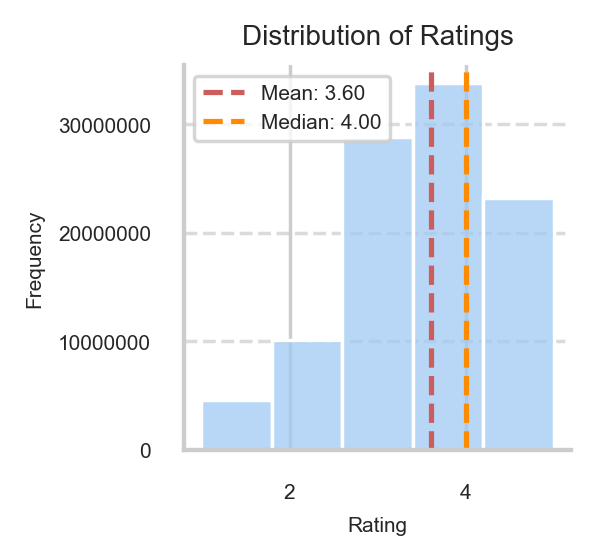

In [39]:
# Set style and color palette
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Visualize the distribution of ratings using a histogram
fig, ax = plt.subplots(figsize=(2, 2), dpi=250)
sns.histplot(data['rating'], bins=5, kde=False, ax=ax)

# Set x and y labels and title
ax.set_xlabel('Rating', fontsize=6)
ax.set_ylabel('Frequency', fontsize=6)
ax.set_title('Distribution of Ratings', fontsize=8)

# Remove spines on the right and top sides
sns.despine(right=True, top=True)

# Add mean and median lines
mean = data['rating'].mean()
median = data['rating'].median()
ax.axvline(mean, color='indianred', linestyle='--', label=f'Mean: {mean:.2f}')
ax.axvline(median, color='darkorange', linestyle='--', label=f'Median: {median:.2f}')
ax.legend(fontsize=6)

# Add gridlines and adjust tick labels
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=6)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=6)

plt.show()


In the plot, the median rating is 4, and the mean rating is 3.6. The median is the middle value in a dataset when the data is sorted, meaning that 50% of the ratings are above this value and 50% are below it. In this case, the median rating is 4, which indicates that half of the movie ratings are 4 or higher, and the other half are lower than 4. This indicates that the distribution of ratings might be slightly skewed to the left.

C:\Users\User\AppData\Local\Temp\ipykernel_27488\3799623592.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=4)
C:\Users\User\AppData\Local\Temp\ipykernel_27488\3799623592.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=4)


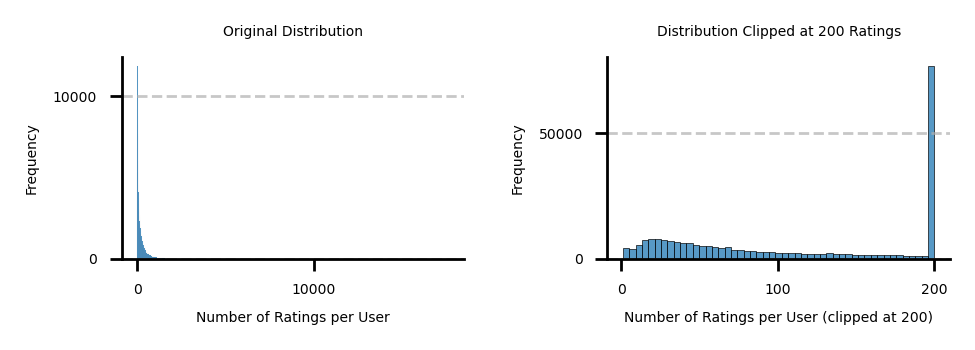

In [53]:
# Count the number of ratings each user gave
ratings_per_user = data['user_id'].value_counts()
ratings_per_user_clipped = ratings_per_user.clip(upper=200)

# Create a 1x2 grid of plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.5), dpi=250)

# Plot the original histogram
sns.histplot(ratings_per_user, kde=False, ax=axes[0])
axes[0].set_xlabel('Number of Ratings per User', fontsize=4)
axes[0].set_ylabel('Frequency', fontsize=4)
axes[0].set_title('Original Distribution', fontsize=4)

# Plot the clipped histogram
sns.histplot(ratings_per_user_clipped, kde=False, ax=axes[1])
axes[1].set_xlabel('Number of Ratings per User (clipped at 200)', fontsize=4)
axes[1].set_ylabel('Frequency', fontsize=4)
axes[1].set_title('Distribution Clipped at 200 Ratings', fontsize=4)

# Remove spines on the right and top sides
sns.despine(right=True, top=True)

# Add gridlines and adjust tick labels
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=4)
    ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=4)

plt.tight_layout()
plt.show()


In [66]:
#count amount of users rated more than 200 movies and amount of users that rated less than 200 movies
print("Number of users that rated more than 200 movies:", ratings_per_user[ratings_per_user > 200].count())
print("Number of users that rated less than 200 movies:", ratings_per_user[ratings_per_user <= 200].count())


Number of users that rated more than 200 movies: 150245
Number of users that rated less than 200 movies: 329944


The two histograms display the distribution of the number of ratings per user. Most users have rated fewer than 200 movies, but there are also many users who have rated more than 200 movies, as shown in the original distribution.

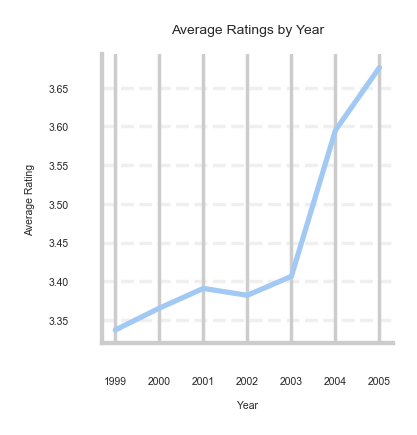

In [60]:
# Explore the relationship between the date of the rating and the rating itself
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
ratings_by_year = data.groupby('year')['rating'].mean()

fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=250)
plt.plot(ratings_by_year)

# Set x and y labels and title
ax.set_xlabel('Year', fontsize=3)
ax.set_ylabel('Average Rating', fontsize=3)
ax.set_title('Average Ratings by Year', fontsize=4)

# Remove spines on the right and top sides
sns.despine(right=True, top=True)

# Add gridlines and adjust tick labels
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=3)

plt.show()



Average user rating went up with the years.

C:\Users\User\AppData\Local\Temp\ipykernel_23500\829148092.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_23500\829148092.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=8)


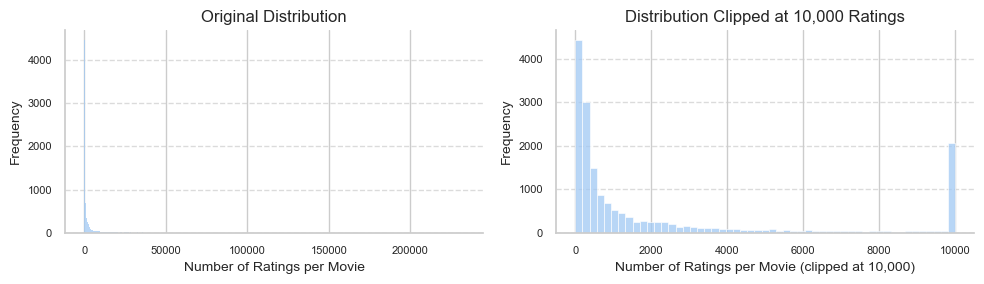

In [65]:
# Count the number of ratings each movie received
ratings_per_movie = data['movie_id'].value_counts()
ratings_per_movie_clipped = ratings_per_movie.clip(upper=10000)

# Create a 1x2 grid of plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=100)

# Plot the original histogram
sns.histplot(ratings_per_movie, kde=False, ax=axes[0])
axes[0].set_xlabel('Number of Ratings per Movie', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title('Original Distribution', fontsize=12)

# Plot the clipped histogram
sns.histplot(ratings_per_movie_clipped, kde=False, ax=axes[1])
axes[1].set_xlabel('Number of Ratings per Movie (clipped at 10,000)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title('Distribution Clipped at 10,000 Ratings', fontsize=12)

# Remove spines on the right and top sides
sns.despine(right=True, top=True)

# Add gridlines and adjust tick labels
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=8)
    ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=8)

plt.tight_layout()
plt.show()



These charts show how often movies get rated. Most movies don't get rated more than 1000 times, meaning that they aren't reviewed as much.


In this code we on focus on the more "active" users and movies. Here's what I did:

1. First, we count how many reviews each user has made. It helps us see who's more active.
2. Then, we find users who have reviewed more than 50 movies. We're interested in these "super-users" because they give us lots of information.
Next, we count how many reviews each movie has gotten. It shows us which movies are more popular.
Lastly, we find movies that have more than 50 reviews. These are the ones that many people have watched and reviewed. Now we have a list of users and movies that are more active or popular. Focusing on these can help our recommendation system because it gives us more information to work with. 

In [51]:
data.shape

(100480507, 5)

In [70]:
# Count the number of ratings per user
user_counts = data['user_id'].value_counts()

# Print the number of users with less than 10 ratings
print("Number of users with less than 25 ratings:", len(user_counts[user_counts < 25]))

Number of users with less than 25 ratings: 70234


In [68]:
# Count the number of ratings per user
movie_counts = data['movie_id'].value_counts()

# Print the number of users with less than 10 ratings
print("Number of movies with less than 50 ratings:", len(movie_counts[movie_counts < 50]))
print("Number of movies with less than 50 ratings:", len(movie_counts[movie_counts < 100]))

Number of movies with less than 50 ratings: 57
Number of movies with less than 50 ratings: 975


In [71]:
# Find users who have reviewed more than 50 movies
user_review_counts = data.groupby('user_id')['movie_id'].count()
users_over_50_reviews = user_review_counts[user_review_counts > 25].index.tolist()

# Find movies that have been reviewed by more than 50 users
movie_review_counts = data.groupby('movie_id')['user_id'].count()
movies_over_50_reviews = movie_review_counts[movie_review_counts > 50].index.tolist()

In [73]:
# Filter the dataframes to only include users who have reviewed more than 25 movies
data = data[data['user_id'].isin(users_over_50_reviews)]

# Filter the dataframes to only include movies that have been reviewed by more than 50 users
data = data[data['movie_id'].isin(movies_over_50_reviews)]

C:\Users\User\AppData\Local\Temp\ipykernel_23500\560218790.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


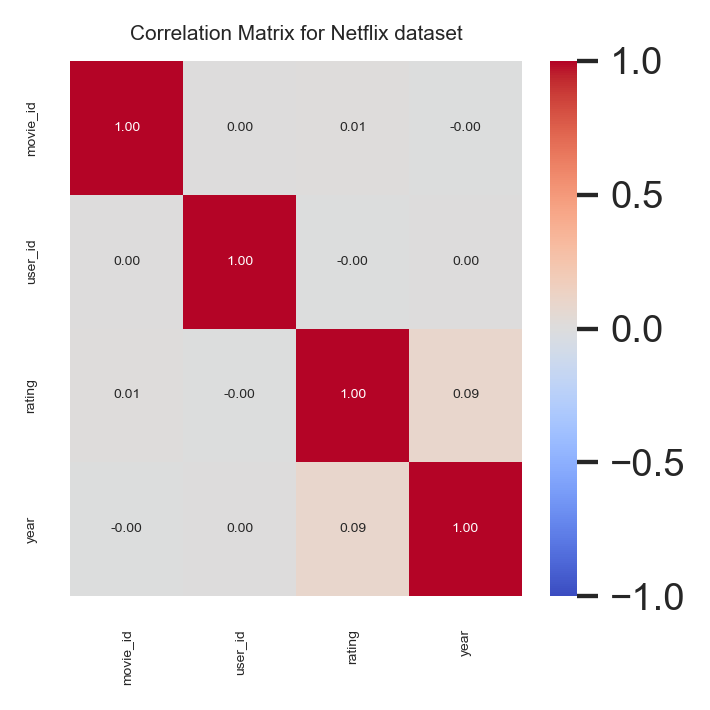

In [92]:
# Calculate correlation matrix for the data
correlation_matrix = data.corr()

# Visualize the correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(3, 3), dpi=250)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
            annot_kws={"fontsize": 4}, fmt=".2f", cbar=True)

# Set the title for the heatmap
ax.set_title('Correlation Matrix for Netflix dataset', fontsize=6)

# Set fontsize for x-axis and y-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=4)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)

plt.tight_layout()
plt.show()


This chart shows the relationships between different parts of the Netflix dataset. It tells us that there isn't a strong connection between the different pieces of information in the dataset.

# 4) Feature Engineering

Because of my enthusiasm for this project I added some features to the datasets. Later I realized that this is not necassery for a RecSys.

Feature engineering can be helpful for some recommendation systems, but not all. It really depends on the type of recommendation system and the algorithm you're using. For example, k-Nearest Neighbors (kNN) and Singular Value Decomposition (SVD) might not benefit much from extra features, because they're all about finding patterns in user-item interactions.

In simple terms, kNN finds similar users or items based on ratings, and SVD uncovers hidden factors by simplifying the user-item matrix. So, adding extra features might not make these algorithms better, since they focus on user-item interactions.

Extra features can still be useful in other types of recommendation techniques, like content-based filtering or hybrid systems. In these cases, more information about items can help improve the recommendations.

In the end, I decided not to use extra features for my project. It's important to know what works best for the algorithm you're using, and sometimes keeping things simple can be just as effective.

In [8]:
# Calculate the average rating of a movie
data['avg_movie_rating'] = data['movie_id'].map(average_ratings)

# Calculate the number of ratings a user has given
user_rating_counts = data['user_id'].value_counts()
data['user_rating_count'] = data['user_id'].map(user_rating_counts)

# Calculate the time since the user's last rating
data['days_since_last_rating'] = data.groupby('user_id')['date'].transform(lambda x: x.diff().dt.days)

# Display the dataset with new features
print(data.head())

   movie_id  user_id  rating       date  year  avg_movie_rating  \
0         1  1488844       3 2005-09-06  2005          3.749543   
1         1   822109       5 2005-05-13  2005          3.749543   
2         1   885013       4 2005-10-19  2005          3.749543   
3         1    30878       4 2005-12-26  2005          3.749543   
4         1   823519       3 2004-05-03  2004          3.749543   

   user_rating_count  days_since_last_rating  
0               2206                     NaN  
1                147                     NaN  
2                366                     NaN  
3               1291                     NaN  
4                647                     NaN  


## Dataframe sizing

Dataframe is so big, it took too long to load. Changed the .CSV format to parquet. Used this video as inspiration: https://www.youtube.com/watch?v=u4rsA5ZiTls&ab_channel=RobMulla.

First need to pip install the Pyarrow library.

In [ ]:
!pip install Pyarrow

In [89]:
import pyarrow.parquet as pq

I will now write the dataset to disk for modelling. There are various formats that can be used to store intermediate datasets for ML, for example: csv, pickle, feather, parquet. I will use parquet in this case.

In [90]:
%timeit data.to_parquet('data.parquet', index=False)

13.2 s ± 429 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Took just 13 seconds compared to about 4 minutes for a csv file.

In [93]:
df = pd.read_parquet('data.parquet')

In [94]:
nan_values = df.isna().any()
print(nan_values)


movie_id    False
user_id     False
rating      False
date        False
year        False
dtype: bool


## Subset of dataset because memory won't allow

So, in this code snippet, we're working with a big dataset. But we want to focus on just a small part of it to make things easier. 

1. First, we find all the unique movie IDs in the dataset. I don't want duplicates.
2. Then, we randomly pick 1000 movie IDs from the unique ones. I just want a small sample.
3. After that, we filter the dataset to keep only the data for those 1000 movie IDs. 

Now we have a smaller dataset with just 1000 movies, which should be easier to work with. 

Sometimes, you have to start small to understand the bigger picture.

In [96]:
# Extract unique movie_ids
unique_movie_ids = df['movie_id'].unique()

# Get a random sample of 1000 movie_ids
random_sample_movie_ids = pd.Series(unique_movie_ids).sample(1000).tolist()

# Filter the dataframe using the random sample of movie_ids
subset_df = df[df['movie_id'].isin(random_sample_movie_ids)]

In [97]:
subset_df.sample(10)

,movie_id,user_id,rating,date,year
43554159,7767,372794,4,2005-07-25,2005
74734682,13651,2401042,3,2005-08-02,2005
18624080,3610,2328967,5,2005-10-11,2005
18654349,3610,2296555,2,2005-02-01,2005
97372808,17381,2397274,5,2005-11-07,2005
59505374,11042,1512547,4,2003-12-09,2003
20378703,3904,1389065,4,2005-04-03,2005
24128969,4577,1449331,2,2001-11-17,2001
35576300,6386,649745,2,2005-09-29,2005
95896829,17169,2604264,5,2005-07-25,2005


Another parquet file because we don't want to reload the big file everytime. Even though it just took 46 seconds.

In [99]:
subset_df.to_parquet('subset_df.parquet', index=False)

In [3]:
#read the subset_df.parquet file
subset_df = pd.read_parquet('subset_df.parquet')

In [101]:
#count amount of different movie_ids
subset_df['movie_id'].nunique()

1000

In [102]:
def percent_missing(subset_df):
    missing = round(subset_df.isnull().sum() * 100 / subset_df.shape[0], 2).sort_values(ascending=False)
    return missing

percent_missing(subset_df)

movie_id    0.0
user_id     0.0
rating      0.0
date        0.0
year        0.0
dtype: float64

For the models we just three columns: user_id, movie_id and rating

In [4]:
#make new dataframe from subset_df with only the columns movie_id, user_id, rating without index
df2 = subset_df[['movie_id', 'user_id', 'rating']].reset_index(drop=True)
df2.head()

,movie_id,user_id,rating
0,9,1329923,2
1,9,2472537,2
2,9,403531,5
3,9,635607,1
4,9,1520914,3


# 5) Analysis

## K-Nearest Neighbours 

USED SOURCES:

harsh vijay (11 April 2020) Recommendation System using kNN [<source code>]. https://www.aurigait.com/blog/recommendation-system-using-knn/

Jake Vanderplas (unknown date) 1.6. Nearest Neighbors
[<source code>]. https://scikit-learn.org/stable/modules/neighbors.html

Ethan Rosenthal (November 2, 2015) Intro to collaborative filtering
[<source code>]. https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In the context of a recommendation system, K-nearest neighbors (KNN) helps to find items that are most similar to a particular item based on user preferences or item features. We have a list of movies and their ratings by users, and we want to recommend movies similar to a specific movie. KNN works by measuring how similar the movies are, based on user ratings and then selecting the "K" most similar movies as recommendations. 

In [41]:
# Create a pivot table with the movie_id as the index, the user_id as the columns, and the ratings as the values
df_pivot = df2.pivot(index="movie_id", columns="user_id", values="rating").fillna(0)
print(df_pivot.shape)

(1000, 399286)


In [12]:
df_pivot.head()

user_id,6,7,8,10,25,33,42,59,79,83,...,2649375,2649376,2649378,2649384,2649388,2649401,2649404,2649409,2649426,2649429
movie_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Convert the pivot table to a sparse matrix
df_matrix=csr_matrix(df_pivot.values)

In [7]:
# Hyperparameter tuning nearest neighbors
algorithm = ['brute']
n_neighbors = [4, 5,6, 7, 8 ,9, 10, 15, 20]
metric = ['cosine']

#writing for loops to find the best hyperparameters
for i in n_neighbors:
    for k in metric:
            for j in algorithm:
                model_knn = NearestNeighbors(metric=k, algorithm=j , n_neighbors=i, n_jobs=-1)
                model_knn.fit(df_matrix)
                distances, indices = model_knn.kneighbors(df_matrix, n_neighbors=i)
            print(f'kneighbors: {i}, algorithm: {j}, metric: {k}, distances: {distances.mean()}')

kneighbors: 4, algorithm: brute, metric: cosine, distances: 0.6180979969577273
kneighbors: 5, algorithm: brute, metric: cosine, distances: 0.6660942447185584
kneighbors: 6, algorithm: brute, metric: cosine, distances: 0.6991596068606838
kneighbors: 7, algorithm: brute, metric: cosine, distances: 0.723586449624885
kneighbors: 8, algorithm: brute, metric: cosine, distances: 0.742398457121526
kneighbors: 9, algorithm: brute, metric: cosine, distances: 0.7574256864740679
kneighbors: 10, algorithm: brute, metric: cosine, distances: 0.7697418343331583
kneighbors: 15, algorithm: brute, metric: cosine, distances: 0.8091943705852631
kneighbors: 20, algorithm: brute, metric: cosine, distances: 0.8313297511307226


In this code, hyperparameter tuning is performed for the nearest neighbors model to find the best combination of parameters. By iterating through various options for the number of neighbors, the distance metric, and the search algorithm, the goal is to find the optimal settings for the model. For each combination, the model is trained, and the average distance between neighbors is calculated. This process helps identify the best performing model configuration to make more accurate recommendations. The inspiration for using for loops in this case came from Valentijn, as the grid search method didn't work for this specific problem.

In [14]:
# Fit the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=4, n_jobs=-1)
model_knn.fit(df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [40]:
#Making a function to get the average rating of a movie
def get_average_rating(movie_id):
    return df2[df2['movie_id'] == movie_id]['rating'].mean()

https://www.geeksforgeeks.org/recommendation-system-in-python/

In [42]:
# Making a function to get the movie title
def get_movie_title(movie_id):
    return movie_titles[movie_titles['movie_id'] == movie_id]['title'].values[0]

# Make a function to get the recommendations
def get_recommendations(movie_id=None):
    # Set the index to the movie_id
    if movie_id is None:
        # If the movie_id is not in the dataframe, get a random movie_id
        query_index = np.random.choice(df_pivot.shape[0])
    # If the movie_id is in the dataframe, get the index
    else:
        query_index = df_pivot.index.get_loc(movie_id)
    # Get the distances and indices of the nearest neighbors
    distances, indices = model_knn.kneighbors(df_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)
    # Get the movie_id of the nearest neighbors
    movie_id = df_pivot.index[query_index]

    # Print the movie title
    print("Movie:", get_movie_title(movie_id))
    print("Top 10 similar movies:")

    # Loop through the distances and indices to print the movie title and distance
    for i in range(1, len(distances.flatten())):  # Start from 1 to skip the movie itself
        # Get the movie_id of the nearest neighbor
        recommended_movie_id = df_pivot.index[indices.flatten()[i]]
        # Get the movie title of the nearest neighbor
        recommended_movie_title = get_movie_title(recommended_movie_id)
        # Get the distance of the nearest neighbor
        distance = distances.flatten()[i]
        # Get the average rating of the nearest neighbor
        avg_rating = get_average_rating(recommended_movie_id)
        # Print the movie title and distance and average rating
        print(f"{i}: {recommended_movie_title}, with an average rating of: {avg_rating:.2f}, with distance of {distance:.5f}")

I created a function that helps to recommend similar movies based on a given movie ID. First, the function finds the movie title for the given movie ID. Then, it uses a model to find the 10 nearest neighbors or most similar movies. For each of these similar movies, it retrieves the movie title, average rating, and the distance from the original movie. Finally, it displays the list of recommended movies along with their average ratings and the distances that show how similar they are to the original movie.

In [38]:
# Get the recommendations for the movie with the movie_id 
df2.sample(10).movie_id

2606295     7399
2836573     7767
4709459    15205
3549770    10550
4253727    14482
292751      1110
3476833    10550
1097061     3610
2877032     8221
2402789     6692
Name: movie_id, dtype: int64

In [48]:
# Calling the get_recommendations function
get_recommendations(6692)

Movie: Entrapment
Top 10 similar movies:
1: The Day After Tomorrow, with an average rating of: 3.44, with distance of 0.47532
2: Air Force One, with an average rating of: 3.70, with distance of 0.48132
3: Men in Black II, with an average rating of: 3.33, with distance of 0.49496
4: Broken Arrow, with an average rating of: 3.26, with distance of 0.52719
5: National Treasure, with an average rating of: 3.81, with distance of 0.54087
6: Sister Act, with an average rating of: 3.20, with distance of 0.54168
7: Patriot Games, with an average rating of: 3.94, with distance of 0.54720
8: Behind Enemy Lines, with an average rating of: 3.52, with distance of 0.55366
9: Lethal Weapon 3, with an average rating of: 3.81, with distance of 0.56451


## SVD


USED SOURCES:

Nicolas Hug  (2015) Using Prediction algorithms [<source code>]. 
https://surprise.readthedocs.io/en/stable/prediction_algorithms.html

George Pipis (19-06-2020) How To Run Recommender Systems In Python[<source code>]. 
https://predictivehacks.com/how-to-run-recommender-systems-in-python/

Nick Becker ( 10 -11 2016) Matrix Factorization for Movie Recommendations in Python[<source code>]. 
https://beckernick.github.io/matrix-factorization-recommender/



Singular Value Decomposition (SVD) is a technique used in recommendation systems to understand complex relationships between users and items. In the context of a recsys, SVD breaks down a large matrix containing user-item ratings into smaller, simpler matrices. By doing so, it can identify hidden patterns and relationships in the data, which can help predict user preferences for items they haven't rated yet. In plain English, SVD simplifies complex data and uses it to make personalized recommendations based on user preferences and item similarities.

In [9]:
df2.head()

,movie_id,user_id,rating
0,9,1329923,2
1,9,2472537,2
2,9,403531,5
3,9,635607,1
4,9,1520914,3


How does the Surprise package work?

1. Decomposition: Break down the user-item rating matrix into three smaller matrices, capturing the underlying patterns and hidden features (latent factors) that explain the ratings.

2. Latent Factors: Discover the hidden characteristics of users and items, such as users' preferences and items' attributes, that are not directly observable but can help predict ratings.

3. Prediction: Use the latent factors to estimate how a user might rate an item they haven't seen before, and provide personalized recommendations based on their preferences and similarities between items.

In [10]:
# create
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_df[['user_id', 'movie_id', 'rating']], reader)

This code is used to prepare the dataset for the SVD model from the Surprise library. The Reader object is created with a rating scale from 1 to 5, specifying the range of possible ratings in the dataset. The data object is then created by loading a subset of the original DataFrame, containing only the 'user_id', 'movie_id', and 'rating' columns, using the load_from_df method from the Dataset module. This formatted data is now ready to be used for training and evaluating the SVD model.

In [11]:
# split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [38]:
movie_titles.head()

,movie_id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [12]:
#
algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

In this code, the SVD model is being created and trained. First, the SVD model is created and stored in the variable algo. Next, the model is trained using the fit method on the training data (trainset). Once the model is trained, it's used to make predictions on the test data (testset) using the test method. The predicted ratings are stored in the variable predictions.

In [13]:
# Compute RMSE
rmse = accuracy.rmse(predictions)

# Compute MAE
mae = accuracy.mae(predictions)

RMSE: 0.9514
MAE:  0.7455


In [49]:
from surprise.model_selection import cross_validate

Performing cross-validation

In [51]:
# perform cross validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# print the results of rmse and mae
print(results['test_rmse'].mean())
print(results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9513  0.9511  0.9494  0.9510  0.9500  0.9506  0.0007  
MAE (testset)     0.7455  0.7447  0.7435  0.7449  0.7438  0.7445  0.0007  
Fit time          77.12   88.18   90.94   83.33   82.40   84.39   4.80    
Test time         14.96   18.95   16.39   15.16   13.41   15.78   1.85    
0.9505607054117127
0.7444984361401678


In the case of this dataset, an RMSE of 0.95105 and an MAE of 0.7444 are relatively good values, considering that the Netflix rating scale is from 1 to 5. These values suggest that, on average, the predicted ratings are less than one unit away from the actual ratings.

The lower values of RMSE and MAE indicate that your model performs well in predicting user ratings for movies.

In [14]:
# get the list of the movie ids
unique_ids = subset_df['movie_id'].unique()

# get the list of the ids that the userid 1001 has rated
iids1001 = subset_df.loc[subset_df['user_id']==1001, 'movie_id']

# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids1001)

In [36]:
def get_movie_recommendations(movies_to_predict, uid, movie_titles):
    my_recs = []

    for movie_id in movies_to_predict:
        predicted_rating = algo.predict(uid=uid, iid=movie_id).est
        my_recs.append((movie_id, predicted_rating))

    recs_df = pd.DataFrame(my_recs, columns=['movie_id', 'predicted_rating'])
    recs_df['predicted_rating'] = recs_df['predicted_rating'].round(2)
    
    # Merge the movie_titles dataset to get the movie names
    recs_df = recs_df.merge(movie_titles, on='movie_id')
    
    # Sort by predicted rating and return the top 10 recommendations
    return recs_df.sort_values('predicted_rating', ascending=False).head(10)

In [37]:
get_movie_recommendations(movies_to_predict, 1001, movie_titles)

,movie_id,predicted_rating,year,title
245,4427,4.62,2001.0,The West Wing: Season 3
479,8664,4.43,2001.0,The Blue Planet: Seas of Life: Ocean World - F...
421,7445,4.38,2004.0,Monk: Season 3
871,16147,4.35,1999.0,The Sopranos: Season 1
830,15406,4.34,1991.0,The House of Eliott: Series 1
14,209,4.33,1996.0,Star Trek: Deep Space Nine: Season 5
123,2117,4.32,2004.0,Case Closed: Season 5
348,6093,4.31,1995.0,House of Cards Trilogy III: The Final Cut
735,13635,4.31,2001.0,The Amazing Race: Season 1
621,11191,4.29,1999.0,South Park: Season 3


The get_movie_recommendations function provides personalized movie recommendations for a user using the SVD model. It calculates predicted ratings for a list of movies, sorts them by the highest predicted ratings, and returns the top 10 movie recommendations most likely to satisfy the user's preferences.

## 6) Conclusion

In this analysis, I have successfully built a personalized movie recommendation system using the Netflix dataset. By implementing machine learning models such as KNN and SVD collaborative filtering techniques, I was able to provide recommendations based on users' preferences and the characteristics of movies they enjoyed.

This recommendation system aimed to maximize user satisfaction, which was measured by the users' movie ratings. The main research question has been answered: "How can we create a personalized movie recommendation system using the Netflix dataset that maximizes user satisfaction, measured by the user's movie ratings?"

As a result, this recommendation system can effectively help users discover new movies they are likely to enjoy, based on their previous ratings and the similarities between movies. This not only enhances user satisfaction but also increases the likelihood of users engaging with the system and returning for more recommendations.

Future work on this project could involve incorporating additional features, such as movie metadata or user demographic information, to further improve the performance of the recommendation system. Also, other machine learning techniques or hybrid approaches could be explored to refine the recommendations and continue to provide users with enjoyable content tailored to their preferences.